In [6]:
import numpy as np
import pandas as pd
import xarray as xr
from xarray import DataArray

import plotly.express as px

# Temperature index models

## Acknowledgment

by Thomas Gölles 2024

## Naive first approach

In [7]:
degree_day_factor = 8.0  # mm/day/degree celsius
temperature_plus = 3.0  # degree celsius
delta_time = 4  # day

melt = degree_day_factor * temperature_plus * delta_time
print(f"melt of snow for {delta_time} is {melt} mm")

melt of snow for 4 is 96.0 mm


Now lets look at the cumulative melt over 10 days

In [8]:
n = 11
days = range(1, n)
melt = 0

for day in days:
    melt = melt + degree_day_factor * temperature_plus * delta_time
    print(f"cummulative melt of snow for {day} is {melt:.2f} mm")

cummulative melt of snow for 1 is 96.00 mm
cummulative melt of snow for 2 is 192.00 mm
cummulative melt of snow for 3 is 288.00 mm
cummulative melt of snow for 4 is 384.00 mm
cummulative melt of snow for 5 is 480.00 mm
cummulative melt of snow for 6 is 576.00 mm
cummulative melt of snow for 7 is 672.00 mm
cummulative melt of snow for 8 is 768.00 mm
cummulative melt of snow for 9 is 864.00 mm
cummulative melt of snow for 10 is 960.00 mm


ok a bit nicer, but the Temperature is still constant. Now use a random tempearature list form -5 to +10

In [9]:
n = 11
days = range(1, n)

np.random.seed(42)
temperatures = np.random.uniform(-5, 10, len(days))
melt = 0

for day in days:
    temperature_plus = temperatures[day - 1]
    melt = melt + degree_day_factor * temperature_plus * delta_time
    print(
        f"cummulative melt of snow for {day} with {temperature_plus:.2f}°C is {melt:.2f} mm"
    )

cummulative melt of snow for 1 with 0.62°C is 19.78 mm
cummulative melt of snow for 2 with 9.26°C is 316.12 mm
cummulative melt of snow for 3 with 5.98°C is 507.48 mm
cummulative melt of snow for 4 with 3.98°C is 634.84 mm
cummulative melt of snow for 5 with -2.66°C is 549.72 mm
cummulative melt of snow for 6 with -2.66°C is 464.60 mm
cummulative melt of snow for 7 with -4.13°C is 332.48 mm
cummulative melt of snow for 8 with 7.99°C is 588.25 mm
cummulative melt of snow for 9 with 4.02°C is 716.78 mm
cummulative melt of snow for 10 with 5.62°C is 896.66 mm


In [10]:
n = 11
days = range(1, n)

np.random.seed(42)
temperatures = np.random.uniform(-5, 10, len(days))
melt = 0

for day in days:
    current_temperature = temperatures[day - 1]
    temperature_plus = np.maximum(current_temperature, 0)
    melt = melt + degree_day_factor * temperature_plus * delta_time
    print(
        f"cummulative melt of snow for {day} with {current_temperature:.2f}°C is {melt:.2f} mm"
    )

cummulative melt of snow for 1 with 0.62°C is 19.78 mm
cummulative melt of snow for 2 with 9.26°C is 316.12 mm
cummulative melt of snow for 3 with 5.98°C is 507.48 mm
cummulative melt of snow for 4 with 3.98°C is 634.84 mm
cummulative melt of snow for 5 with -2.66°C is 634.84 mm
cummulative melt of snow for 6 with -2.66°C is 634.84 mm
cummulative melt of snow for 7 with -4.13°C is 634.84 mm
cummulative melt of snow for 8 with 7.99°C is 890.60 mm
cummulative melt of snow for 9 with 4.02°C is 1019.14 mm
cummulative melt of snow for 10 with 5.62°C is 1199.01 mm


## Better use of Python

If you often reuse a culation but it in a function.
A function starts with "def" then the function name you want to have followed by the input argumetnts in ().

Here I also used so called typehints like degree_day_factor: float. Which means that we expect a floating point number as the degree day factor. In Python this optional but helps a lot in understanding what is expected.

Here I also give a default value of the threshold_temp. This means that if no third argument is given the standard value of 0.0 is used.

In [11]:
def degree_day_model(
    temperatures: np.ndarray | DataArray,
    degree_day_factor: float,
    threshold_temp: float = 0.0,
) -> np.ndarray | DataArray:
    """
    Estimate daily melt amount using the Degree-Day Model.

    Parameters:
    temperatures (numpy.array): Array of daily mean air temperatures (°C).
    degree_day_factor (float): Degree-day factor (mm °C^-1 day^-1).
    threshold_temp (float): Threshold temperature above which melting occurs (°C). Default is 0.0°C.

    Returns:
    numpy.array: Array of daily melt amounts (mm).
    """
    # Calculate positive temperature differences (temperatures above the threshold)
    positive_temperatures = np.maximum(temperatures - threshold_temp, 0)

    # Calculate daily melt amounts
    daily_melt = positive_temperatures * degree_day_factor

    return daily_melt

In [12]:
temperatures = np.array([-3.2, -1.1, 0.0, 2.2, 5.1, 3.0, 0.0, -2.0])

In [13]:
ddf = 8.0
melt_amounts = degree_day_model(temperatures, degree_day_factor=ddf)
melt_amounts

array([ 0. ,  0. ,  0. , 17.6, 40.8, 24. ,  0. ,  0. ])

note here we used the default value for threshold_temp.
So the result is an array of values correspondig to daily temperatures.
To make it nicer to work with lets make a pandas dataframe together with the temperatures

In [14]:
from operator import index


melt = pd.DataFrame(
    melt_amounts,
    index=temperatures,
    columns=[f"melt (mm)"],
)
melt.index.name = "Temperature (°C)"
melt

,melt (mm)
Temperature (°C),
-3.2,0.0
-1.1,0.0
0.0,0.0
2.2,17.6
5.1,40.8
3.0,24.0
0.0,0.0
-2.0,0.0


<Axes: xlabel='Temperature (°C)'>

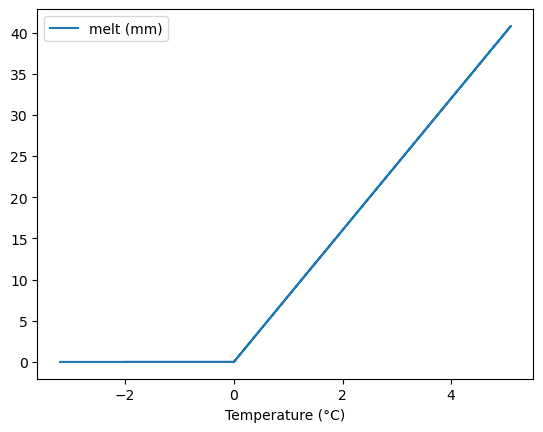

In [15]:
melt.plot()

### Exersize

* plot the curve for different degree day factors.
* compare snow and ice: 2.5 to 11.6 mm/(day K)  for snow 6.6 to 20.0 mm/(day K) for ice,
* change the function to use SI base units

What is the total amount of melt in mm over all days

In [16]:
melt["melt (mm)"].sum()

82.4

## Spatial distributed version

![INCA data auschnitt](figures/Pasterze.png)

In [17]:
inca_pasterze = xr.open_dataset(
    "/workspaces/Modellieren in der Physischen Geographie/data/inca_pasterze.nc"
)

In [18]:
inca_pasterze

<xarray.Dataset>
Dimensions:                  (time: 192, y: 9, x: 8)
Coordinates:
    lambert_conformal_conic  float64 ...
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2023-07-01 ... 2023-07-08T...
  * x                        (x) int32 349000 350000 351000 ... 355000 356000
  * y                        (y) int32 352000 353000 354000 ... 359000 360000
Data variables:
    T2M                      (time, y, x) float32 ...
    GL                       (time, y, x) float64 ...
    P0                       (time, y, x) float64 ...
    RH2M                     (time, y, x) float32 ...
    RR                       (time, y, x) float64 ...
    TD2M                     (time, y, x) float32 ...
    UU                       (time, y, x) float32 ...
    VV                       (time, y, x) float32 ...
Attributes: (12/14)
    Conventions:         CF-1.7
    author:              Alexander Kann (alexander.kann@zamg.ac.at), Benedikt...
    comment:             No additional comments
    crs:                 EPSG:31287
    freq:                1H
    grid_mapping:        lambert_conformal_conic
    ...                  ...
    name:                incal-hourly
    references:          https://www.zamg.ac.at/cms/de/forschung/wetter/inca ...
    source:              modeled data
    spatial_domain:      INCAL
    spatial_resolution:  1000
    title:               INCA analysis - large domain

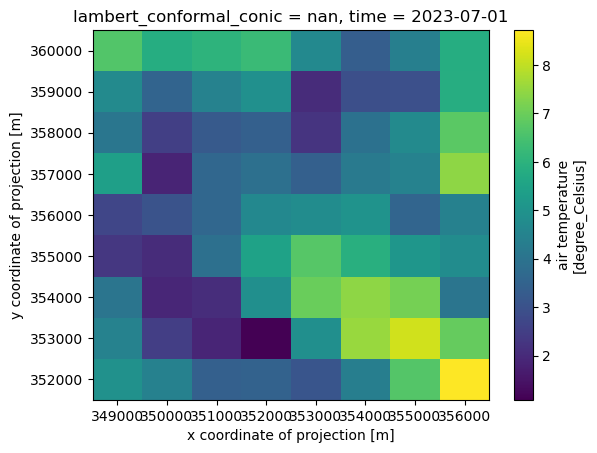

In [19]:
temperatures = inca_pasterze["T2M"]
temperature_example = temperatures.sel(time="2023-07-01T00:00:00")
temperature_example.plot()

In [20]:
type(temperature_example)

xarray.core.dataarray.DataArray

In [21]:
melt_amounts_distributed = degree_day_model(temperature_example, degree_day_factor=ddf)
melt_amounts_distributed.name = "melt (mm)"

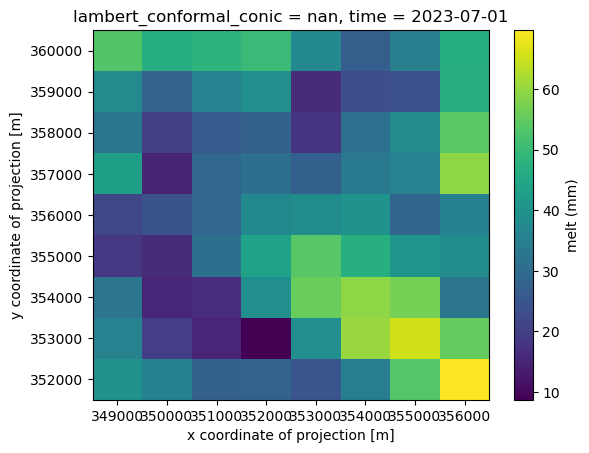

In [22]:
melt_amounts_distributed.plot()

## Now with space and time

In [23]:
tempeartures = inca_pasterze["T2M"]
tempeartures

<xarray.DataArray 'T2M' (time: 192, y: 9, x: 8)>
[13824 values with dtype=float32]
Coordinates:
    lambert_conformal_conic  float64 ...
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2023-07-01 ... 2023-07-08T...
  * x                        (x) int32 349000 350000 351000 ... 355000 356000
  * y                        (y) int32 352000 353000 354000 ... 359000 360000
Attributes:
    cell_method:     
    description:     air temperature 2m above ground
    esri_pe_string:  PROJCS["MGI / Austria Lambert",GEOGCS["MGI",DATUM["Milit...
    grid_mapping:    lambert_conformal_conic
    long_name:       air temperature
    standard_name:   surface_temperature
    units:           degree_Celsius

In [30]:
melt_result = degree_day_model(temperatures, degree_day_factor)
melt_result.name = "melt (mm)"

In [31]:
melt_result

<xarray.DataArray 'melt (mm)' (time: 192, y: 9, x: 8)>
array([[[39.44    , 35.2     , 27.119999, ..., 34.559998, 53.52    ,
         69.76    ],
        [35.44    , 19.76    , 14.96    , ..., 60.32    , 65.28    ,
         55.44    ],
        [32.48    , 15.36    , 16.4     , ..., 59.44    , 56.96    ,
         32.399998],
        ...,
        [32.64    , 20.16    , 25.68    , ..., 31.519999, 37.68    ,
         54.16    ],
        [37.68    , 28.08    , 35.52    , ..., 23.359999, 23.519999,
         46.719997],
        [53.28    , 46.48    , 48.239998, ..., 26.72    , 34.88    ,
         46.559998]],

       [[36.88    , 32.399998, 24.24    , ..., 31.599998, 51.6     ,
         68.32    ],
        [32.8     , 16.88    , 12.24    , ..., 58.96    , 64.159996,
         53.28    ],
        [29.84    , 12.639999, 13.599999, ..., 58.      , 55.52    ,
         29.199999],
...
        [46.079998, 29.92    , 36.88    , ..., 43.68    , 50.399998,
         68.799995],
        [52.8     , 40.64    , 49.2     , ..., 33.52    , 33.76    ,
         60.16    ],
        [62.96    , 59.199997, 54.16    , ..., 37.36    , 48.32    ,
         59.76    ]],

       [[52.559998, 47.2     , 38.8     , ..., 47.28    , 58.239998,
         71.84    ],
        [48.079998, 29.599998, 24.4     , ..., 59.199997, 65.439995,
         65.36    ],
        [44.8     , 24.32    , 25.84    , ..., 57.44    , 57.12    ,
         45.28    ],
        ...,
        [46.399998, 30.64    , 37.44    , ..., 43.68    , 50.64    ,
         69.84    ],
        [52.879997, 41.12    , 49.36    , ..., 34.32    , 34.559998,
         61.28    ],
        [61.52    , 57.6     , 52.239998, ..., 38.079998, 46.8     ,
         61.199997]]], dtype=float32)
Coordinates:
    lambert_conformal_conic  float64 ...
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2023-07-01 ... 2023-07-08T...
  * x                        (x) int32 349000 350000 351000 ... 355000 356000
  * y                        (y) int32 352000 353000 354000 ... 359000 360000

In [34]:
import plotly.graph_objects as go

ds = melt_result.to_dataset()

In [37]:
frames = []

# Loop through each time step to create frames
for t in range(len(melt_result.time)):
    # Format the timestamp for displaying
    time_str = str(np.datetime_as_string(melt_result.time.values[t], unit="h"))

    # Create a frame for each time step
    frame = go.Frame(
        data=[
            go.Heatmap(
                z=melt_result.isel(time=t).values,
                x=melt_result.x.values,
                y=melt_result.y.values,
                zmin=0,  # Set minimum value of z-axis
                zmax=150,  # Set maximum value of z-axis
                colorscale="Viridis",
            )
        ],
        name=time_str,
        layout=go.Layout(
            title=f"Melt Pattern on {time_str}",  # Update title with current time
            annotations=[
                dict(
                    showarrow=False,
                    text=time_str,  # Show time on the plot
                    xref="paper",
                    yref="paper",
                    x=0.5,
                    y=1.05,
                    xanchor="center",
                    yanchor="bottom",
                    font=dict(size=14),
                )
            ],
        ),
    )
    frames.append(frame)

# Create initial figure
fig = go.Figure(
    data=[
        go.Heatmap(
            z=melt_result.isel(time=0).values,
            x=melt_result.x.values,
            y=melt_result.y.values,
            zmin=0,  # Set minimum value of z-axis
            zmax=150,  # Set maximum value of z-axis
            colorscale="Viridis",
        )
    ],
    layout=go.Layout(
        title=f"Melt Pattern on {str(np.datetime_as_string(melt_result.time.values[0], unit='h'))}",
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(
                        label="Play",
                        method="animate",
                        args=[
                            None,
                            {
                                "frame": {"duration": 500, "redraw": True},
                                "fromcurrent": True,
                            },
                        ],
                    ),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                            },
                        ],
                    ),
                ],
            )
        ],
    ),
    frames=frames,
)

# Show the figure
fig.show()